In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path='/content/drive/MyDrive/Colab Notebooks/Normal forest images.zip'
extract_path='/content/fire_dataset_normal'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall(extract_path)

print("Done extracting to",extract_path)

Done extracting to /content/fire_dataset_normal


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir='/content/fire_dataset_normal/Forest Fire Dataset/Training'


img_height,img_weight=224,224
batch_size=32

datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

traingen=datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_weight),
    batch_size=batch_size,
    class_mode='binary',

)

valgen=datagen.flow_from_directory(
    data_dir,
    target_size=(img_height,img_weight),
    batch_size=batch_size,
    class_mode='binary',

)

Found 1520 images belonging to 2 classes.
Found 1520 images belonging to 2 classes.


In [ ]:
print(" fire images:", len(os.listdir("/content/fire_dataset_normal/Forest Fire Dataset/Training/fire")))
print(" normal images:", len(os.listdir("/content/fire_dataset_normal/Forest Fire Dataset/Training/nofire")))

In [ ]:
print(traingen.class_indices)

{'fire': 0, 'nofire': 1}


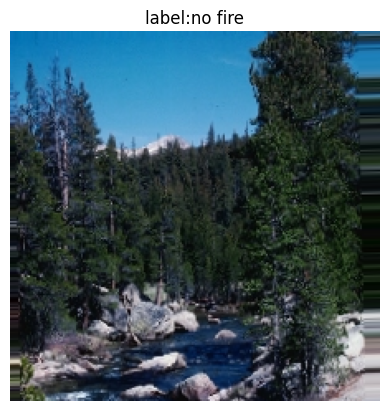

In [ ]:
import matplotlib.pyplot as plt

image,label=next(traingen)

plt.imshow(image[0])
plt.title("label:"+("fire" if label[0]==0 else "no fire"))
plt.axis('off')
plt.show()


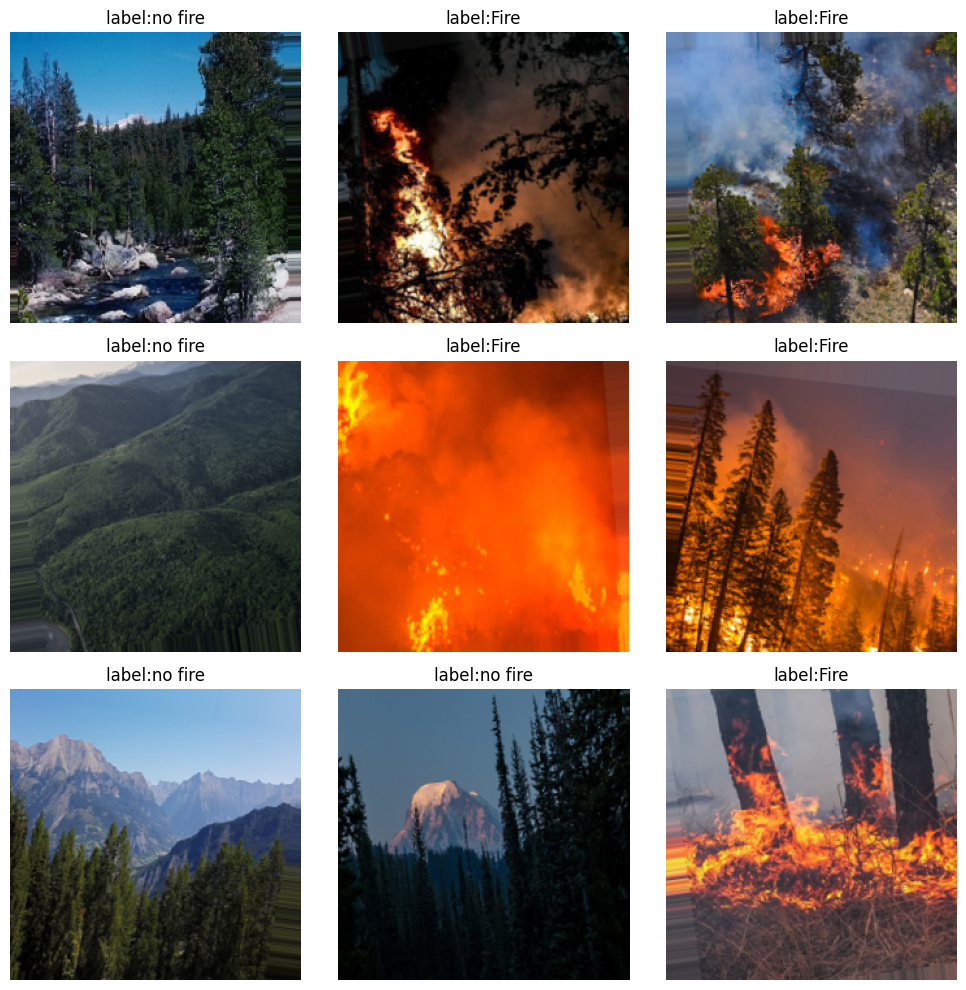

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(image[i])
  plt.title("label:"+("Fire" if label[i]==0 else "no fire"))
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras import layers,models

model=models.Sequential([
    layers.Conv2D(32,(3,3), activation='relu', input_shape=(img_height,img_weight,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64,(3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,841 (45.64 MB)

 Trainable params: 11,963,649 (45.64 MB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

earlystop=EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reducelr=ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history=model.fit(
    traingen,
    validation_data=valgen,
    epochs=25,
    callbacks=[earlystop,reducelr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8473 - loss: 7.3013

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 887ms/step - accuracy: 0.8482 - loss: 7.2674 - val_accuracy: 0.5059 - val_loss: 15.4530 - learning_rate: 0.0010
Epoch 2/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 838ms/step - accuracy: 0.8816 - loss: 3.6902 - val_accuracy: 0.5000 - val_loss: 43.0167 - learning_rate: 0.0010
Epoch 3/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 832ms/step - accuracy: 0.9132 - loss: 2.0911 - val_accuracy: 0.6375 - val_loss: 14.1709 - learning_rate: 0.0010
Epoch 4/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 834ms/step - accuracy: 0.9041 - loss: 1.2552 - val_accuracy: 0.6684 - val_loss: 14.0556 - learning_rate: 0.0010
Epoch 5/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 839ms/step - accuracy: 0.9160 - loss: 1.3464 - val_accuracy: 0.7566 - val_loss: 11.3142 - learning_rate: 0.0010
Epoch 6/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 822ms/step - accuracy: 0.9004 - loss: 0.9897 - val_accuracy: 0.5342 - val_loss: 23.3949 - learning_rate: 0.0010
Epoch 7/25
48/48 ━━━━━━━━━━━━━━━━━━━━ 41s 833ms/step - accuracy: 0.9173 - loss: 0.9790 

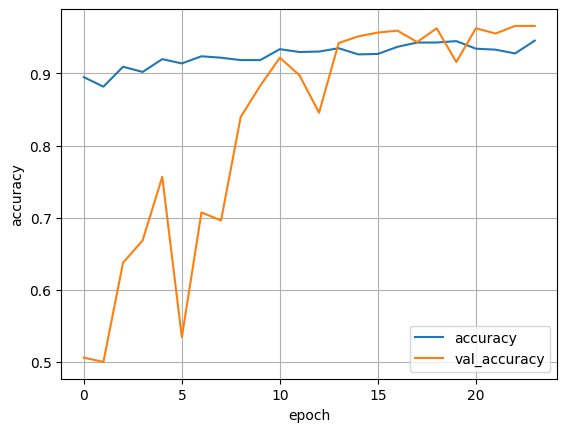

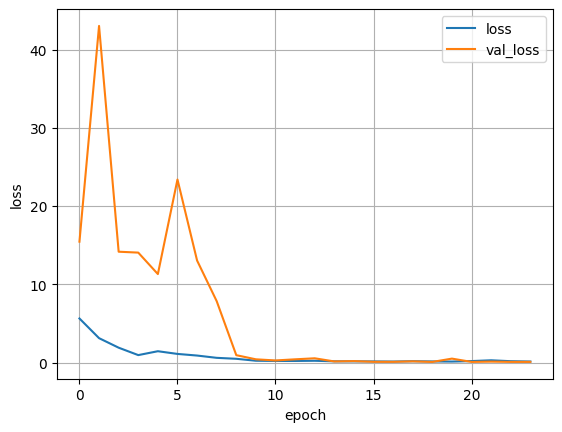

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/nbest_fire_detection_model.keras')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
model_path='/content/drive/MyDrive/Colab Notebooks/nbest_fire_detection_model.keras'
model=load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step


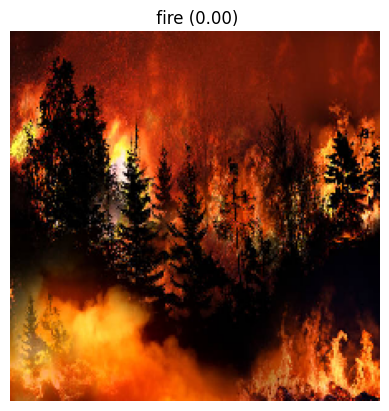

In [ ]:
img_path='/content/drive/MyDrive/Colab Notebooks/forest fire images/forest fire.jpg'

img=image.load_img(img_path, target_size=(224,224))
img_arr=image.img_to_array(img)
img_arr=img_arr/255.0

img_arr=np.expand_dims(img_arr,axis=0)

prediction=model.predict(img_arr)[0][0]

plt.imshow(img)
plt.axis('off')
plt.title(f" {'fire' if prediction < 0.5 else 'no fire'} ({prediction:.2f})")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


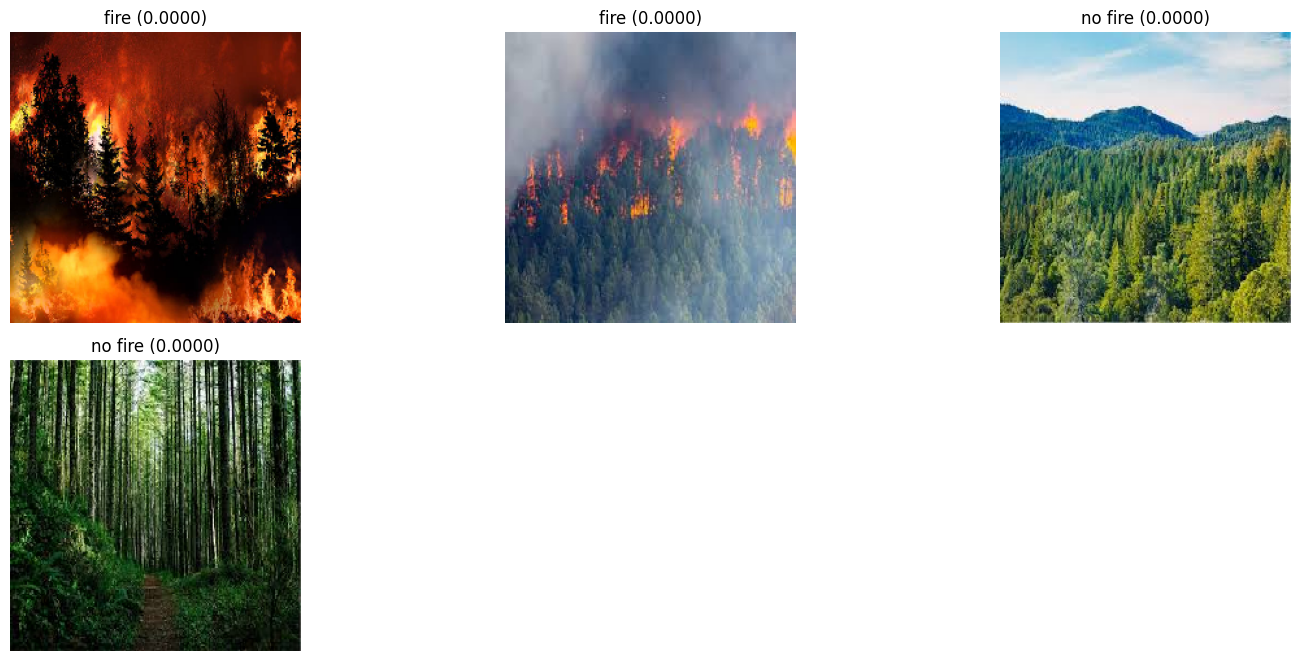

In [ ]:
img_folder='/content/drive/MyDrive/Colab Notebooks/forest fire images'

img_files=[f for f in os.listdir(img_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]

plt.figure(figsize=(15,10))

for i,img_name in enumerate(img_files):
  img_path2=os.path.join(img_folder,img_name)

  img2=image.load_img(img_path2,target_size=(224,224))
  img_arr2=image.img_to_array(img2)
  img_arr2=img_arr2/255.0

  img_arr2=np.expand_dims(img_arr2,axis=0)

  prediction2=model.predict(img_arr2)[0][0]

  plt.subplot(3,3,i+1)
  plt.imshow(img2)
  plt.axis('off')
  plt.title(f'{"fire" if prediction2 < 0.5 else "no fire"} ({prediction:.4f})')

plt.tight_layout()
plt.show()